<h2 align=center><font size = 4>IBM Data Science Capstone - Final Project</font></h2>
<h1 align=center><font size = 5>Market Perception of Major Banks in New York</font></h1>

## Introduction

Retail banking remains a highly competitive business, with banks aiming to gain any edge on the competition. Although several services are conducted online, many other services are provided to customers at office branches. 

The perception of customers towards their bank is highly important in assessing the performance of banks around cities where they operate in order to plan future improvements. 

We propose a project to gain insights in the market perception of major banks in New York by performing a sentiment analysis on the text feedback provided by customers visiting various banks of this branch.


## Import necessary libraries

In [92]:
# Load packages
import configparser
import folium
import matplotlib
import matplotlib.cm     as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import nltk
import numpy             as np
import pandas            as pd
import re
import requests
import seaborn           as sns
import string

from geopy.geocoders   import Nominatim 
from matplotlib.ticker import MaxNLocator
from nltk.corpus       import stopwords
from nltk.tokenize     import word_tokenize
from sklearn.cluster   import KMeans
from textblob          import TextBlob
from typing            import List, Set, Dict, Tuple, Optional

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set()

#nltk.download('punkt')
stop_words = set(stopwords.words('english'))


## FourSquare API Configuration

A class is defined to manage FourSquare API credentials and parameters

In [2]:
class FourSquareConfig:
    
    def __init__(self, config_file: str):
        # FourSquare Credentials
        config = configparser.RawConfigParser()
        config.read(config_file)
        credentials = dict(config.items('FOURSQUARE'))

        # Foursquare Configuration
        self.CLIENT_ID = credentials['client_id']
        self.CLIENT_SECRET = credentials['client_secret']
        self.VERSION = '20180605' # Foursquare API version
        self.LIMIT = 100000 # A default Foursquare API limit value
        
fsc = FourSquareConfig('4square.cfg')

## Bank Data

We start by collecting and storing the venues under the category 'Bank'.

In [3]:
def get_location(address: str):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    return location.latitude, location.longitude


def parse_venues(response: Dict):
    
    # Check if is a valid response
    if 'response' not in response.keys():
        return None
    
    # Check if any venues in response
    if 'venues' not in response['response'].keys():
        return None
    
    # For each venue in response
    data = pd.DataFrame()
    for venue in response['response']['venues']:
        
        # Parse venue
        new_data = pd.DataFrame({'id': venue['id'], 'name': venue['name'], 
                                 'distance': venue['location']['distance'],
                                 'lat': venue['location']['lat'], 
                                 'lng': venue['location']['lng']}, index=[0])
        
        # Add venue
        data = pd.concat([data, new_data])
        
        # Clean data
        data['name'] = data['name'].str.replace(',', ' ')

    return data.reset_index(drop=True)


def fs_query_venues_by_category(categoryId: str, address: str, radius: int):

    # Get address location
    lat, lng = get_location(address)

    # Make request URL
    base_url = 'https://api.foursquare.com/v2/venues/search?'
    params   = f'client_id={fsc.CLIENT_ID}&client_secret={fsc.CLIENT_SECRET}&ll={lat},{lng}&v={fsc.VERSION}&categoryId={categoryId}&radius={radius}&limit={fsc.LIMIT}'
    url      = base_url+params
    
    # Execute request
    response = requests.get(url).json()
    
    # Return venues as a pandas dataframe
    return parse_venues(response)


# Request parameters    
address    = 'New York City, NY'
radius     = 30000 
categoryId = '4bf58dd8d48988d10a951735' # Category = Banks

# Make request
#bank = fs_query_venues_by_category(categoryId, address, radius)
bank = pd.read_csv('ny_banks.csv')

# Sample data
print('Number of rows: ', bank.shape[0])
bank.head()

Number of rows:  50


,id,name,distance,lat,lng
0,543baecf498ea44ee2c1a5da,TD Bank,556,40.707852,-74.004576
1,5022b54ce4b04ac74d74c5ac,TD Bank,14361,40.680440,-73.841264
2,51098c83f470bb33c867c0e5,Citigroup Global Headquarters,977,40.720608,-74.011116
3,4e6ac8f145ddadf2d0a36ad4,Castle Check Cashing,14428,40.833709,-73.944593
4,4d2cfb67aa5c6ea8627da904,I Love Lucy's,21986,40.884826,-73.877998


We visualize the venue count by Bank

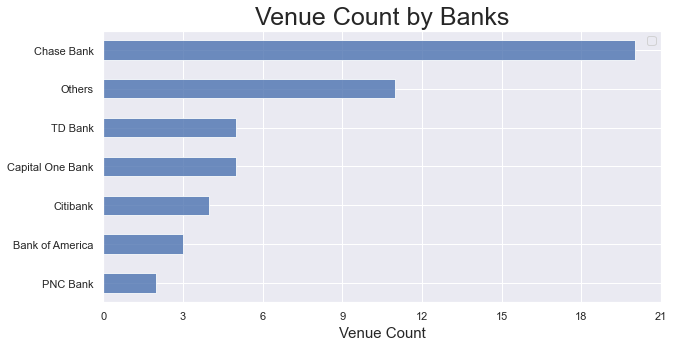

In [4]:
# Compute banks summary
bank_summary = pd.DataFrame(bank['name'].value_counts()).reset_index()
mask = bank_summary['name']<=1
bank_summary.loc[mask, 'index'] = 'Others'
bank_summary.rename(columns={'index': 'name', 'name': 'count'}, inplace=True)
bank_summary = bank_summary.groupby(['name']).sum().reset_index()
bank_summary.sort_values(by='count', inplace=True)

# Plot banks summary
ax = bank_summary.plot.barh(x='name', y='count', figsize=(10,5), alpha=0.8)
ax.set_ylabel('')
ax.set_xlabel('Venue Count', fontsize=15)
ax.legend('')
ax.set_title('Venue Count by Banks', fontsize=25)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


Finally, we add a column to indicate the bank to which each venue belongs to, and save the data

In [5]:
# Add bank name column based on summary
mask = bank['name'].isin(bank_summary['name'].tolist())
bank.loc[~mask,'bank'] = 'Others'
bank.loc[mask,'bank'] = bank['name']

# Save data
bank.to_csv('ny_banks.csv', index=False)

# Sample data
bank.head()

,id,name,distance,lat,lng,bank
0,543baecf498ea44ee2c1a5da,TD Bank,556,40.707852,-74.004576,TD Bank
1,5022b54ce4b04ac74d74c5ac,TD Bank,14361,40.680440,-73.841264,TD Bank
2,51098c83f470bb33c867c0e5,Citigroup Global Headquarters,977,40.720608,-74.011116,Others
3,4e6ac8f145ddadf2d0a36ad4,Castle Check Cashing,14428,40.833709,-73.944593,Others
4,4d2cfb67aa5c6ea8627da904,I Love Lucy's,21986,40.884826,-73.877998,Others


We conclude this section by ploting the venues on a map

In [197]:
# Assign color to each bank
colors = {'TD Bank': 'blue', 'Others': 'gray', 'PNC Bank': 'red', 'Chase Bank': 'green',
          'Bank of America': 'yellow', 'Citibank': 'orange', 'Capital One Bank': 'brown'} 

# Get address location
lat, lng = get_location(address)

venues_map = folium.Map(location=[lat, lng], zoom_start=10)

for _, row in bank.iterrows():
    folium.CircleMarker(
        [row['lat'], row['lng']],
        radius=8,
        popup=row['bank'],
        fill=True,
        color=colors[row['bank']],
        fill_color=colors[row['bank']],
        fill_opacity=0.8
        ).add_to(venues_map)

# display map
venues_map

## Tips Data

For the banks previously retrieved, we collect the available tips.

In [6]:
def parse_tips(response: Dict):
    
    # Check if is a valid response
    if 'response' not in response.keys():
        return None
    
    # Check if any venues in response
    if 'tips' not in response['response'].keys():
        return None
    
    # For each venue in response
    data = pd.DataFrame()
    for tip in response['response']['tips']['items']:
        
        # Parse tip
        new_data = pd.DataFrame({'id': tip['id'], 'createdAt': tip['createdAt'], 
                                  'text': tip['text'], 'lang': tip['lang']}, index=[0])
        
        # Add tip
        data = pd.concat([data, new_data])
        
        # Clean data
        data['text'] = data['text'].str.replace('\\', ' ')

    return data.reset_index(drop=True)


def fs_query_one_venue_tips(venueId: str):

    # Get address location
    lat, lng = get_location(address)

    # Make request URL
    base_url = f'https://api.foursquare.com/v2/venues/{venueId}/tips?'
    params   = f'client_id={fsc.CLIENT_ID}&client_secret={fsc.CLIENT_SECRET}&v={fsc.VERSION}&limit={fsc.LIMIT}'
    url      = base_url+params
    
    # Execute request
    response = requests.get(url).json()
    
    # Return venues as a pandas dataframe
    return parse_tips(response)

def fs_query_all_venues_tips(venueIds: List[str]):
    
    # For each venue
    data = pd.DataFrame()
    for venueId in venueIds:
        
        # Get venue tips
        new_data = fs_query_one_venue_tips(venueId)
        if new_data is not None:
            new_data['venueId'] = venueId
        
        # Add venue tips
        data = pd.concat([data, new_data])
        
    return data.reset_index(drop=True)

# Make request
venueIds = bank['id'].tolist()
#tips     = fs_query_all_venues_tips(venueIds)
tips = pd.read_csv('ny_bank_tips.csv')

# Sample data
tips.head()

,venueId,id,createdAt,text,lang,bank
0,5022b54ce4b04ac74d74c5ac,520a798511d257e4ee57bf4c,1.376418e+09,Coming for their coin counting service? Don't ...,en,TD Bank
1,51098c83f470bb33c867c0e5,54c1f49e498e6e802d9b4ad2,1.421997e+09,For healthy snacks hit the green grocer cart o...,en,Others
2,4c6ae00aa48420a1d2b5080b,58898f5f9435a95cbdc4c4dd,1.485410e+09,My family has used this bank for over 2 decade...,en,Others
3,4c0ea0d37189c92876cfd8b6,51b0d4d8498e1772912f8b03,1.370543e+09,Nice & quiet. Little or no lines at all!!,en,Bank of America
4,4b8ea09ff964a520e22c33e3,4e25a49d18388c58be2df369,1.311090e+09,They are always courteous & efficient.,en,Chase Bank


Based on the venue id, we add the bank name to each tip

In [7]:
for index, row in tips.iterrows():
    bank_name = bank.loc[bank['id'] == row['venueId'], 'bank'].values[0]
    tips.loc[index, 'bank'] = bank_name

tips.head()

,venueId,id,createdAt,text,lang,bank
0,5022b54ce4b04ac74d74c5ac,520a798511d257e4ee57bf4c,1.376418e+09,Coming for their coin counting service? Don't ...,en,TD Bank
1,51098c83f470bb33c867c0e5,54c1f49e498e6e802d9b4ad2,1.421997e+09,For healthy snacks hit the green grocer cart o...,en,Others
2,4c6ae00aa48420a1d2b5080b,58898f5f9435a95cbdc4c4dd,1.485410e+09,My family has used this bank for over 2 decade...,en,Others
3,4c0ea0d37189c92876cfd8b6,51b0d4d8498e1772912f8b03,1.370543e+09,Nice & quiet. Little or no lines at all!!,en,Bank of America
4,4b8ea09ff964a520e22c33e3,4e25a49d18388c58be2df369,1.311090e+09,They are always courteous & efficient.,en,Chase Bank


We visualize the tips count by bank

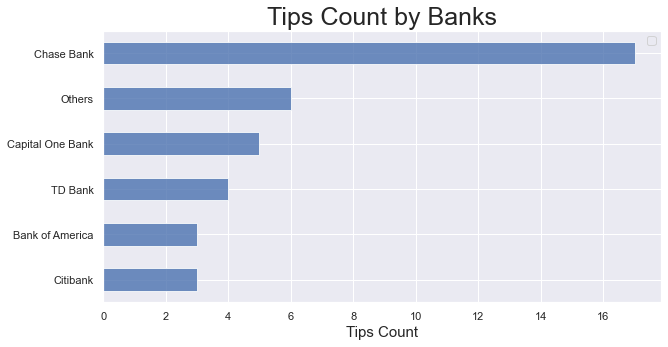

In [8]:
# Compute summary
tips_summary = tips['bank'].value_counts().to_frame().reset_index()
tips_summary.rename(columns={'index': 'bank', 'bank': 'count'}, inplace=True)
tips_summary.sort_values(by='count', inplace=True)
tips_summary

# Plot tips summary
ax = tips_summary.plot.barh(x='bank', y='count', figsize=(10,5), alpha=0.8)
ax.set_ylabel('')
ax.set_xlabel('Tips Count', fontsize=15)
ax.legend('')
ax.set_title('Tips Count by Banks', fontsize=25)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


Finally, we store the tips data

In [9]:
# Save data
tips.to_csv('ny_bank_tips.csv', index=False)

## Sentiment Analysis

Using the data about banks and their corresponding tips, we conduct a sentiment analysis.

First, we preprocess the text in tips data

In [10]:
def preprocess_text(text):
    
    # Set all text to lower case
    text = text.lower()
    
    # Remove invalid characters
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    text_tokens = word_tokenize(text)
    filtered_words = [w for w in text_tokens if not w in stop_words]
    
    return " ".join(filtered_words)

# Load data
tips = pd.read_csv('ny_bank_tips.csv')

# Use only tips in English language
tips = tips[tips['lang'] == 'en']

print('Before preprocessing:\n', tips['text'].tolist()[0])

# Preprocess text 
tips['text'] = tips['text'].apply(preprocess_text)

print('\nAfter preprocessing:\n', tips['text'].tolist()[0])


Before preprocessing:
 Coming for their coin counting service? Don't bother. Screen will say "Penny isn't feeling well." Like EVERY time. I hate to break it to you, but after a year, Penny's dead.

After preprocessing:
 coming coin counting service dont bother screen say penny isnt feeling well like every time hate break year pennys dead


We proceed to compute a sentiment score using TextBlob. 

In [138]:
def analyze_sentiment(text):
    analysis = TextBlob(text)

    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
# Compute sentiment score 
tips['sentiment'] = tips['text'].apply(analyze_sentiment)

# Sample result
print('Here is an example of the sentiment score on two tip\'s text:\n\n')
print('Text: ', tips['text'].tolist()[0], '\n')
print('Sentiment score: ', tips['sentiment'].tolist()[0], '\n')

print('Text: ', tips['text'].tolist()[3], '\n')
print('Sentiment score: ', tips['sentiment'].tolist()[3])

Here is an example of the sentiment score on two tip's text:


Text:  coming coin counting service dont bother screen say penny isnt feeling well like every time hate break year pennys dead 

Sentiment score:  -1 

Text:  nice quiet little lines 

Sentiment score:  1


We visualize the mean sentiment score for each bank. This will be the market perception.

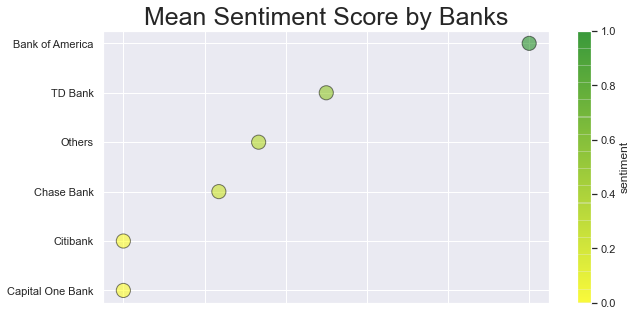

In [195]:
# Compute sentiment summary
sentiment_summary = tips.groupby(['bank']).agg({'sentiment':'mean'}).reset_index()
sentiment_summary.sort_values(by='sentiment', inplace=True)

# Plot sentiment summary
cmap = matplotlib.colors.LinearSegmentedColormap.from_list([0,1], ["yellow","green"])
ax = sentiment_summary.plot.scatter(x='sentiment', y='bank', s=200, c='sentiment', 
                                  colormap=cmap, figsize=(10,5), alpha=0.5, edgecolor='black')
ax.set_ylabel('')
ax.set_title('Mean Sentiment Score by Banks', fontsize=25)
plt.show()


## Conclussions

The sentiment analysis conducted in this project provides us with several valuable insights:

- Based on the collected data, Bank of America has a mean sentiment score of 1, placing it as the bank with best market perception in New York. This comes with the caveat that Bank of America is at the bottom half in number of venues and number of tips provided by customers. In short the reported market perception for Bank of America is positve but very representative due to the low amount of data available for this bank


- Chase Bank has the most venues and tips, making its sentiment score the most significant to report. Their sentiment score is at 0.23, a score slighly above neutral. 


- None of the evaluated banks report a negative market perception. However the results are not statistically significant due to the modest volume of data available.


- This approach is a viable way to gain insights into the market perception of banks in any given location, given that sufficient data is collected.
